# Weighing Milky Way Satellites with LISA

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.constants as sc
import matplotlib.cm as cm 
from scipy import interpolate
from scipy.integrate import simps
from scipy.special import factorial
from scipy.stats import poisson
from matplotlib import colors
from matplotlib import ticker 
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from chainconsumer import ChainConsumer
import emcee
from matplotlib import rc
rc('font',**{'family':'serif','serif':['TX Times']})
rc('text', usetex=True)

### First, we upload satellites models from Korol et al. 2020 https://arxiv.org/abs/2002.10462
### They consist of 11 x 11 grids for number of LISA detections per 1 Solar mass in age (Gyr) along 0-axis and distance (kpc) along 1-axis
### In total we supply three models for three different star formation histories (SFHs): 

### - exponentially declining 
### - constantly starforming 
### - single burst 

In [2]:
N_bins_d = 10
N_bins_age = 10

d_vec = np.logspace(0,2,N_bins_d+1)
age_vec = np.logspace(0,1,N_bins_age+1) 
age_grid, d_grid = np.meshgrid(age_vec,d_vec)

Ndet_grid_exp = np.load('sats_models/Ndet_grid_exp.npy')
Ndet_grid_const = np.load('sats_models/Ndet_grid_const.npy')
Ndet_grid_burst = np.load('sats_models/Ndet_grid_burst.npy')

### Function interpolationg the above grids
interp_Ndet_grid_const = interpolate.interp2d(age_vec, d_vec, Ndet_grid_const, kind='cubic')
interp_Ndet_grid_burst = interpolate.interp2d(age_vec, d_vec, Ndet_grid_burst, kind='cubic')
interp_Ndet_grid_exp = interpolate.interp2d(age_vec, d_vec, Ndet_grid_exp, kind='cubic')

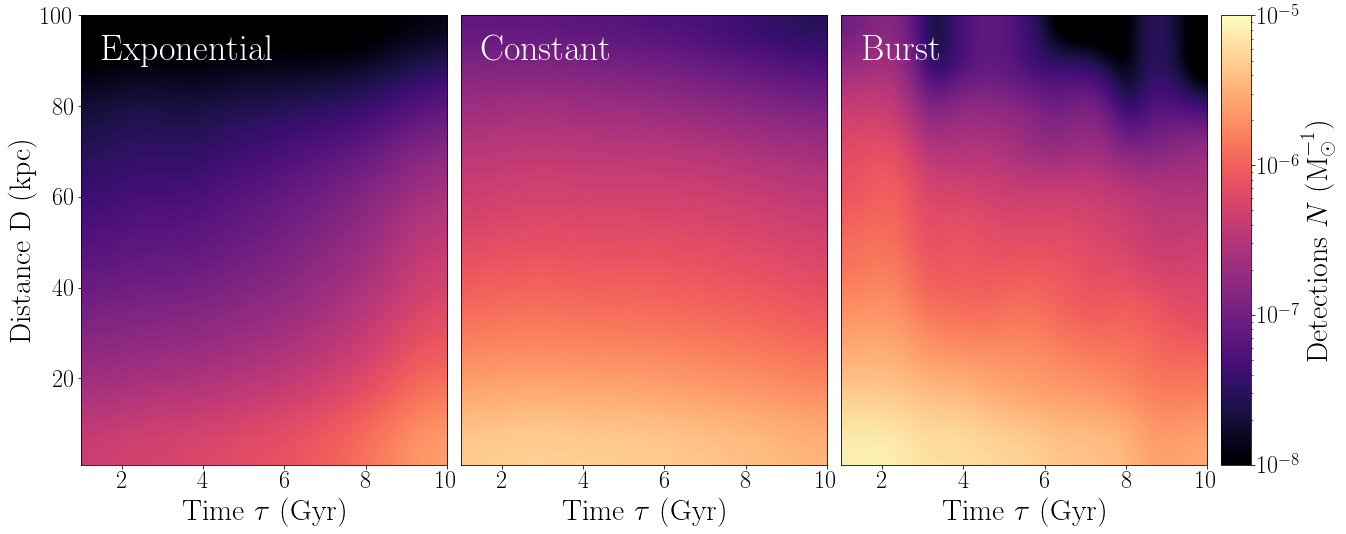

In [3]:
fig, (ax1, ax2, ax3, cax) = plt.subplots(ncols=4, figsize=(21.1,8), gridspec_kw={'wspace': 0.05,"width_ratios":[1,1,1,0.08]}) 
fig.subplots_adjust(left=0.08,right=0.85,top=0.9,bottom=0.12)

im1=ax1.imshow(Ndet_grid_exp, norm=colors.LogNorm(vmin=1e-8, vmax=1e-5), alpha=1.,interpolation="bicubic", 
                origin='lower', cmap='magma',extent=([age_vec[0], age_vec[-1], d_vec[0], d_vec[-1]]), aspect='auto')
ax1.set_ylabel(r'Distance D (kpc)', fontsize=30)
ax1.set_xlabel(r'Time $\tau$ (Gyr)',fontsize=30)
ax1.tick_params(axis='both', which='major', labelsize=24)
ax1.text(1.5,90,r'Exponential', fontsize=36, color = 'w',weight='bold')


im2=ax2.imshow(Ndet_grid_const, norm=colors.LogNorm(vmin=1e-8, vmax=1e-5), alpha=1.,interpolation="bicubic", 
                origin='lower', cmap='magma',extent=([age_vec[0], age_vec[-1], d_vec[0], d_vec[-1]]), aspect='auto')
ax2.set_xlabel(r'Time $\tau$ (Gyr)',fontsize=30)
ax2.tick_params(axis='both', which='major', labelsize=24)
ax2.text(1.5,90,r'Constant', fontsize=36, color = 'w',weight='bold')
ax2.set_yticks([])

im3=ax3.imshow(Ndet_grid_burst, norm=colors.LogNorm(vmin=1e-8, vmax=1e-5), alpha=1.,interpolation="bicubic", 
                origin='lower', cmap='magma',extent=([age_vec[0], age_vec[-1], d_vec[0], d_vec[-1]]), aspect='auto')
cbar = plt.colorbar(im3,cax=cax)
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(24)
cbar.set_label(r'Detections $N$ (M$_\odot^{-1}$)',fontsize=30)#, fontname="Arial")#Signal-to-noise ratio', fontsize=22)
ax3.set_xlabel(r'Time $\tau$ (Gyr)',fontsize=30)
ax3.tick_params(axis='both', which='major', labelsize=24)
ax3.text(1.5,90,r'Burst', fontsize=36, color = 'w', weight='bold')
ax3.set_yticks([])

plt.show()

### As an example, let's consider the case of the Sagittarius dwarf galaxy. We assume that the galaxy can be identified in the LISA data as an overdensity against the Galactic foreground. Therefore, we assume that LISA will provide us the number of detections associated with the dwarf galaxy and the measurement of the distance to it.
### We consider the true parameters of the galaxy to be:

### - Total stellar mass: $M_{\star} = 2.1 \times 10^{7}$ M$_{\odot}$ (e.g. McConnachie 2012 https://arxiv.org/abs/1204.1562, Vasiliev & Belokurov 2020 https://arxiv.org/abs/2006.02929)
### -  Distance: $d = 25 $kpc (e.g. McConnachie 2012 https://arxiv.org/abs/1204.1562), the error is arbitrary assumed to be 10% of the true distance to allow DWD populate the whole volume of the galaxy
### - Number of detected DWD with LISA after 4 years of mission: 10 (Korol et al. 2020 https://arxiv.org/abs/2002.10462)

In [7]:
true_mass= 2.1e7
number_of_detections = 10
measured_d = 25 #in kpc
error_d = 0.1*measured_d
true_distance = measured_d
true_age = 6. #It does not really matter for later

### Our three star formation models predict the number of detecteble DWDs at the true distance for the true mass of the galaxy as shown below:

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


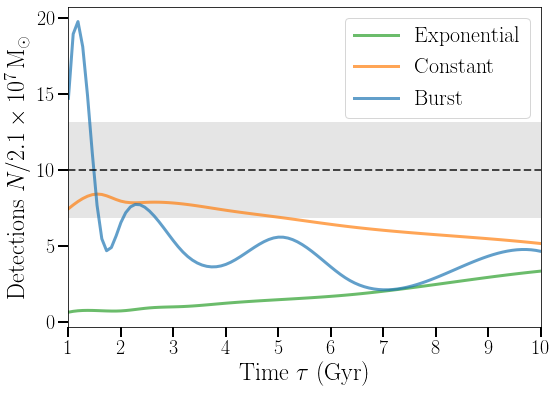

In [5]:
#interp_Ndet_grid_const(age_vec,35)*true_mass
age_vec1 = np.linspace(1,10,100)
fig,axs = plt.subplots(figsize=(8,6))
plt.subplots_adjust(left=0.13,right=0.95,top=0.89,bottom=0.15) 
plt.plot(age_vec1,interp_Ndet_grid_exp(age_vec1,true_distance)*true_mass,label='Exponential',color='C2', alpha=0.7, lw=3)
plt.plot(age_vec1, interp_Ndet_grid_const(age_vec1,true_distance)*true_mass,label='Constant',color='C1', alpha=0.7, lw=3)
plt.plot(age_vec1, interp_Ndet_grid_burst(age_vec1,true_distance)*true_mass,label='Burst',color='C0', alpha=0.7, lw=3)
plt.axhline(y=number_of_detections, color='k',linestyle='--',alpha=0.7,lw=2)
plt.axhspan(number_of_detections-np.sqrt(number_of_detections), number_of_detections+np.sqrt(number_of_detections), 
            facecolor='C7', alpha=0.2)
plt.ylabel(r'Detections $N/2.1\times 10^7\,$M$_\odot$',fontsize=24)
plt.xlabel(r'Time $\tau$ (Gyr)',fontsize = 24)
plt.tick_params(axis='both', which='major', labelsize=20) 
plt.locator_params(axis='x', nbins=10)
axs.tick_params('both', length=10, width=2, which='major')
axs.tick_params('both', length=5, width=1, which='minor')
plt.legend(loc=1,fontsize=22)
axs.set_xlim([1,10])
plt.show()

### Using Bayes’ theorem, we write the posterior on the mass as

$$
p(M_\star| N) = {\cal L}(M_\star | N) \pi (M_\star)
$$
### where L (𝑁|𝑀★, 𝜏, 𝐷) is the likelihood with 𝜏 being time since the beginning of the star formation, 𝜋(𝑀★, 𝜏, 𝐷) is the prior (we will not need the normalising Bayesian evidence). In our inference problem the likelihood is the probability that 𝑁 sources are produced from a generative model of the satellite galaxy.

### For a given SFH, our inference problem require the time since the start of the star formation and the distance (in order to assess LISA selection effects) to predict the number of detections at present time per unit Solar mass 𝜇(𝜏, 𝐷). The number of detections can then be re-scaled to the mass of a satellite; the expected number of sources is written 𝜆 = 𝑀★𝜇(𝜏, 𝐷), where 𝜇(𝜏, 𝐷) is computed from our models and interpolated over a 2D grid of distances and times (as above). In addition, we assume that the LISA event count follows a Poisson distribution, and therefore write
$$
{\cal L}(N|M_\star,\tau,D) = \text{Poisson}\big(N; \lambda[M_\star, \tau,D]\big) = \frac{\lambda^N\exp(-\lambda)}{N!}
$$
### We chose a uniform prior in $\log M_\star$ in the range $10^6 - 10^{10}\,$M$_\odot$, where the lower mass end corresponds roughly to a minimum satellite mass required to host at least one LISA detection and the upper end to the mass of the largest Milky Way satellite (the Large Magellanic Cloud, LMC).

### The distance to the satellite is usually known, either from electromagnetic or GW observations. Therefore we adopt a Gaussian prior centered on the true distance and with a standard deviation equal to the measurement error. For the constant SFH model we adopt a uniform prior in $\log \tau$ in the range 1 - 10\,Gyr.We limit the prior on $\tau$ to 1 - 6\,Gyrs for the single burst SFH model as it is more appropriate for young stellar populations. Vice versa, we limit the age prior for the exponential model to 4 - 10\,Gyr because this SFH is more representative of an old stellar population.

### We sample the posterior using the affine invariant sampler emcee to measure the stellar mass.

In [6]:
def loguniform(value, low, up):
    if value<low or value>up:
        return -np.inf
    else:
        return 1.

def lognormal(value, mu, sd):
    y=(value-mu)/sd
    return -0.5*y*y

def lnprior(theta):
    age_sat, d_sat, mass_sat = theta
    
    lnp=0
    lnp+=loguniform(mass_sat, 1e6, 1e10)
    lnp+=loguniform(age_sat, 1, 10)
    lnp+=lognormal(d_sat, measured_d, error_d)
    
    return lnp 


def lnlike(theta,Nobs,d_obs,err_d): 
    age_sat, d_sat, mass_sat=theta
    
    mu = interp_Ndet_grid_const(age_sat,d_sat)*mass_sat #here we interpolated from the grid generated with the constant star formation model
    sigma = np.sqrt(mu)
    y=(Nobs-mu)/sigma
    y2=y*y
    
    return  -0.5*np.sum(y2)

def lnlike(theta,Nobs,d_obs,err_d): 
    age_sat, d_sat, mass_sat=theta
    
    mu = interp_Ndet_grid_const(age_sat,d_sat)*mass_sat
    
    return poisson.logpmf(Nobs, mu)

def lnpost(theta, Nobs, d, err_d):
    Vlnprior=lnprior(theta)
    if np.isfinite(Vlnprior)==False:
        return -np.inf
    
    Vlnlike=lnlike(theta,Nobs,d, err_d)
    if np.isfinite(Vlnlike)==False:
        return -np.inf
    
    return Vlnprior+Vlnlike



ndim=3 #number of free parameters: age, distance, total stellar mass
nwalkers= 100 
#initial position of walkers
def start():
    return (np.random.uniform(1, 10), 
            np.random.normal(true_distance, 10), 
            np.random.normal(true_mass, 0.3*true_mass))
pos = [ start() for i in range(nwalkers)] 

ncpu=5
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnpost, args=(number_of_detections,measured_d,error_d),threads=ncpu) #args are the artuments of lnpost exept theta
nstep=10000
#Number of posterior samples = nwalkers*nstep
sampler.run_mcmc(pos, nstep) 
samples_const = sampler.chain[:, :, :].reshape((-1, ndim)) #samples contains nstep*ndim evaluations of lnprob and is ordered in columns by free parameters

### Let's plot the posteriors.

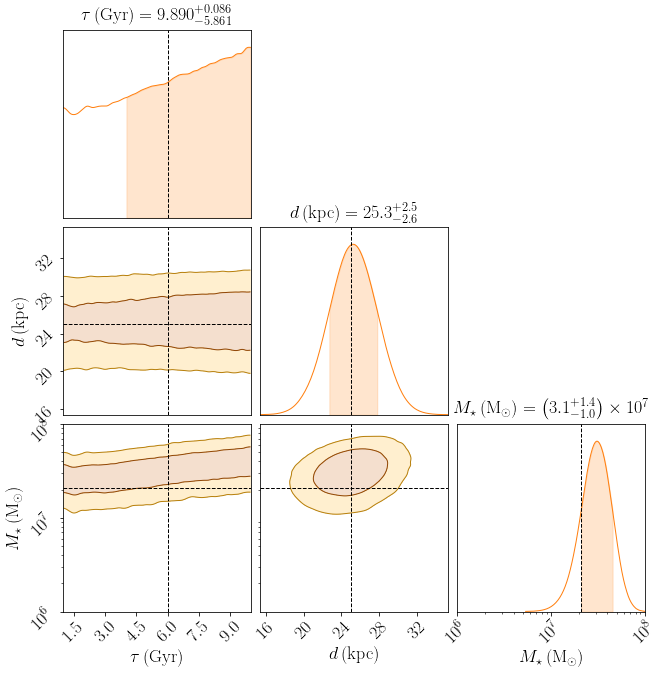

In [8]:
truth = [true_age,true_distance,true_mass]

c = ChainConsumer().add_chain(samples_const, parameters=[r"$\tau\,({\rm Gyr})$", r"$d\,({\rm kpc})$", r"$M_{\star}\,({\rm M}_{\odot})$"])
c.configure(tick_font_size=18, label_font_size=18, max_ticks=6,shade=True, colors=[colors.to_hex('C1')],shade_alpha=0.2)
fig = c.plotter.plot(truth=truth, log_scales=[False,False,True],extents={r"$M_{\star}\,({\rm M}_{\odot})$": (1e6,1e8)})
fig.set_size_inches(5 + fig.get_size_inches())  # Resize fig for doco. You don't need this.

### From this corner plot it can be seen that counting the number of LISA sources in a satellite does not provide a good measurement of the age. It also does not provide a good measurement of the distance (we essentially recover the Gaussian prior). However, it does provide a measurement of the stellar mass.


### Let's now repeat the same for the other two SFH models.

In [9]:
def lnprior(theta):
    age_sat, d_sat, mass_sat = theta
    
    lnp=0
    lnp+=loguniform(mass_sat, 1e6, 1e10)
    lnp+=loguniform(age_sat, 4, 10)
    lnp+=lognormal(d_sat, measured_d, error_d)
    
    return lnp 


def lnlike(theta,Nobs,d_obs,err_d): 
    age_sat, d_sat, mass_sat=theta
    
    mu = interp_Ndet_grid_exp(age_sat,d_sat)*mass_sat
    sigma = np.sqrt(mu)
    y=(Nobs-mu)/sigma
    y2=y*y
    
    return  -0.5*np.sum(y2)

from scipy.stats import poisson
def lnlike(theta,Nobs,d_obs,err_d): 
    age_sat, d_sat, mass_sat=theta
    
    mu = interp_Ndet_grid_exp(age_sat,d_sat)*mass_sat #here we interpolated from the grid generated with the exponential star formation model
    
    return poisson.logpmf(Nobs, mu)

def lnpost(theta, Nobs, d, err_d):
    Vlnprior=lnprior(theta)
    if np.isfinite(Vlnprior)==False:
        return -np.inf
    
    Vlnlike=lnlike(theta,Nobs,d, err_d)
    if np.isfinite(Vlnlike)==False:
        return -np.inf
    
    return Vlnprior+Vlnlike



ndim=3 #number of free parameters
nwalkers= 100 
#initial position of walkers
def start():
    return (np.random.uniform(5, 10), 
            np.random.normal(true_distance, 10), 
            np.random.normal(true_mass, 0.3*true_mass))#10**np.random.normal(np.log10(true_mass), 1.0))#
pos = [ start() for i in range(nwalkers)] 

ncpu=4
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnpost, args=(number_of_detections,measured_d,error_d),threads=ncpu) #args are the artuments of lnpost exept theta
nstep=10000
#Number of posterior samples = nwalkers*nstep
sampler.run_mcmc(pos, nstep) 
samples_exp = sampler.chain[:, :, :].reshape((-1, ndim)) 

In [10]:
def lnprior(theta):
    age_sat, d_sat, mass_sat = theta
    
    lnp=0
    lnp+=loguniform(mass_sat, 1e6, 1e10)
    lnp+=loguniform(age_sat, 1, 6)
    lnp+=lognormal(d_sat, measured_d, error_d)
    
    return lnp 


def lnlike(theta,Nobs,d_obs,err_d): 
    age_sat, d_sat, mass_sat=theta
    
    mu1 = 1.17
    mu2 = 1.4
    sigma1 = 0.02
    sigma2 = 0.02
    
    Mexp = frac
    
    y=(Mobs-Mexp)/sigma
    y2=y*y
    
    return  -0.5*np.sum(y2)

def lnlike(theta,Nobs,d_obs,err_d): 
    age_sat, d_sat, mass_sat=theta
    
    mu = interp_Ndet_grid_burst(age_sat,d_sat)*mass_sat #here we interpolated from the grid generated with the burst star formation model
    
    return poisson.logpmf(Nobs, mu)

def lnpost(theta, Nobs, d, err_d):
    Vlnprior=lnprior(theta)
    if np.isfinite(Vlnprior)==False:
        return -np.inf
    
    Vlnlike=lnlike(theta,Nobs,d, err_d)
    if np.isfinite(Vlnlike)==False:
        return -np.inf
    
    return Vlnprior+Vlnlike



ndim=3 #number of free parameters
nwalkers= 100 
#initial position of walkers
def start():
    return (np.random.uniform(1, 6),
            np.random.normal(true_distance, 10), 
            np.random.normal(true_mass, 0.3*true_mass))
pos = [ start() for i in range(nwalkers)] 

ncpu=5
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnpost, args=(10,measured_d,error_d),threads=ncpu) #args are the artuments of lnpost exept theta
nstep=10000
#Number of posterior samples = nwalkers*nstep
sampler.run_mcmc(pos, nstep) 
samples_burst = sampler.chain[:, :, :].reshape((-1, ndim)) 

### Let's display all the results on the same corner plot

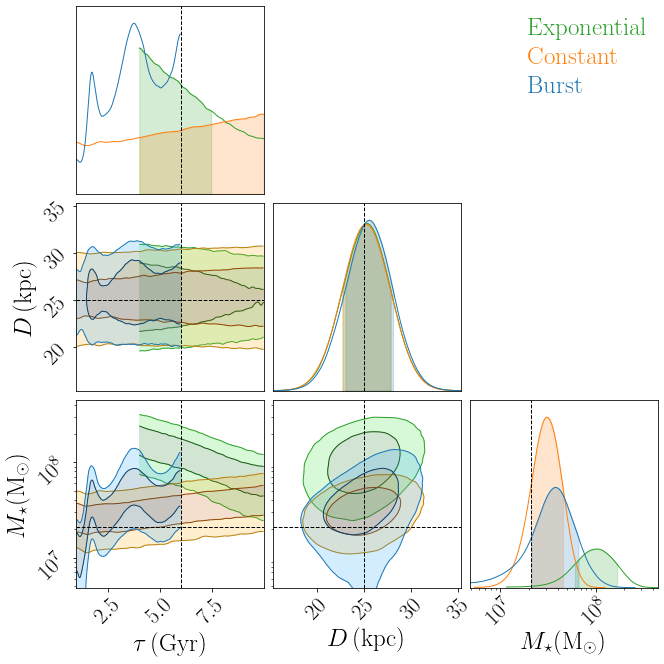

In [11]:
truth = [true_age,true_distance,true_mass]
parameters=[r"$\tau\,({\rm Gyr})$", r"$d\,({\rm kpc})$", r"$M_{\star} ({\rm M}_{\odot})$"]
c = ChainConsumer()
c.add_chain(samples_exp, parameters=[r"$\tau\,({\rm Gyr})$", r"$D\,({\rm kpc})$", r"$M_{\star} ({\rm M}_{\odot})$"],name="Exponential")
c.add_chain(samples_const, parameters=[r"$\tau\,({\rm Gyr})$", r"$D\,({\rm kpc})$", r"$M_{\star} ({\rm M}_{\odot})$"],name="Constant")
c.add_chain(samples_burst, parameters=[r"$\tau\,({\rm Gyr})$", r"$D\,({\rm kpc})$", r"$M_{\star} ({\rm M}_{\odot})$"],name="Burst")
c.configure(tick_font_size=22, label_font_size=25, max_ticks=4,colors=[colors.to_hex('C2'),colors.to_hex('C1'),colors.to_hex('C0')],
            shade=True, shade_alpha=0.2)
fig = c.plotter.plot(truth=truth,log_scales=[False,False,True])
fig.set_size_inches(5 + fig.get_size_inches()) 

### Voilà!